In [9]:
# Imports
%matplotlib notebook
import numpy as np
import pylgmath
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from matplotlib.text import Annotation
from pylgmath.so3.operations import vec2rot
from utils import plotting
from utils import sim
from utils import local_solver

In [10]:
# camera parameters
f_u = 100 # focal length in horizonal pixels
f_v = 100 # focal length in vertical pixels
c_u = 50 # pinhole projection in horizonal pixels
c_v = 50 # pinhold projection in vertical pixels
b = 0.2 # baseline (meters)

M = sim.make_stereo_camera_matrix(f_u, f_v, c_u, c_v, b)
R = 2 * np.eye(4) # covarience matrix for image-space noise


<IPython.core.display.Javascript object>


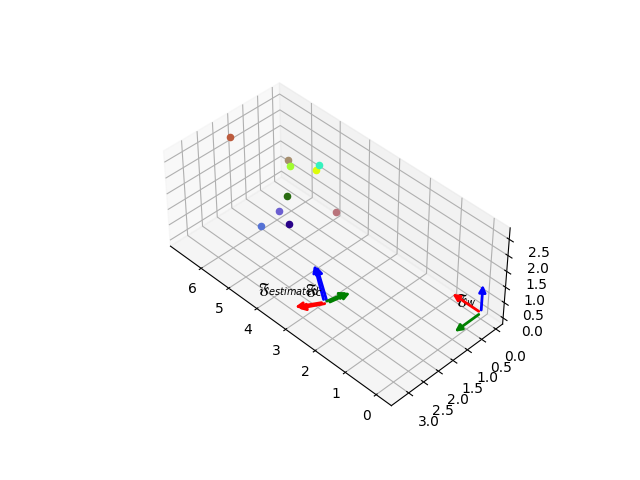

<IPython.core.display.Javascript object>


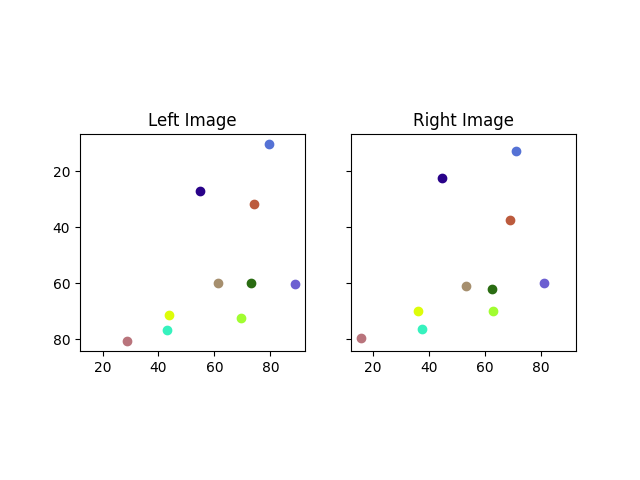

In [14]:
# make random camera pose
a = np.random.rand(3, 1)
theta = np.random.rand() * 2*np.pi
C_wc = vec2rot(theta * a/np.linalg.norm(a))
T_wc = np.eye(4)
T_wc[:3, :3] = C_wc
T_wc[:-1, -1] = [3*np.random.rand(), 3*np.random.rand(), 0]

# make sim instance w/ N points
N = 10
fig, ax, p_w, colors = sim.make_stereo_sim_instance(N, T_wc, np.array([[-1,1], [-1, 1], [2, 5]]))

# Generative camera model 
T_cw = np.linalg.inv(T_wc)
y = sim.generative_camera_model(M, T_cw, p_w)
dy = sim.generate_stereo_camera_noise(R, size = 10)[:, :, None]
y = y + dy
camfig, (l_ax, r_ax) = sim.render_camera_points(y, colors)

## Stereo Localization Problem
$$\mathbf{T_{cw}} = \frac{1}{2} \text{argmin}_{\mathbf{T}} \sum_k (\mathbf{y}_k - \mathbf{M} \frac{1}{z_k} \mathbf{T} \mathbf{p}_k)^T \mathbf{W}_k (\mathbf{y}_k - \mathbf{M} \frac{1}{z_k} \mathbf{T} \mathbf{p}_k)$$
$$\mathbf{T} \in SE(3)$$
$$z_k = \mathbf{a}^T \mathbf{T} \mathbf{p}_k$$


## Local Solver
Let $\mathbf{x} = \mathbf{T}\mathbf{p}_k$,
$$\mathbf{u}_k(\mathbf{x}) = \mathbf{y}_k - \frac{1}{\mathbf{a}^T\mathbf{x}} \mathbf{M} \mathbf{x}$$

We want to find a perturbation $\mathbf{\epsilon}^*$ so we can iterativly update our estimate $\mathbf{T}$:
$$\mathbf{T} \leftarrow \exp(\mathbf{\epsilon}^{*^{\curlywedge}}) \mathbf{T}_{op}$$

$$\mathbf{u}_k(\mathbf{T} \mathbf{p}_k) \approx \mathbf{u}_k(\mathbf{T}_{op}\mathbf{p}_k) + \frac{\partial \mathbf{u}_k}{\partial \mathbf{x}}|_{\mathbf{x} = \mathbf{T}_{op} \mathbf{p}_k} (\mathbf{T}_{op}\mathbf{p}_k)^{\odot} \mathbf{\epsilon}$$
$$\mathbf{u}_k(\mathbf{T} \mathbf{p}_k) \approx \mathbf{\beta}_k + \mathbf{\delta}^T\mathbf{\epsilon}$$

where
$$\delta_k^T = \frac{\partial \mathbf{u}_k}{\partial \mathbf{x}}|_{\mathbf{x} = \mathbf{T}_{op} \mathbf{p}_k} (\mathbf{T}_{op}\mathbf{p}_k)^{\odot},$$
$$\beta_k = \mathbf{u}_k(\mathbf{T}_{op}\mathbf{p}_k),$$
$$\frac{\partial \mathbf{u}(\mathbf{x})}{\partial \mathbf{x}} = \left(\frac{1}{\mathbf{a}^T \mathbf{x}}\right)^2 \mathbf{M} \mathbf{x} \mathbf{a}^T - \frac{1}{\mathbf{a}^T \mathbf{x}} \mathbf{M}$$

Inserting this back into the cost function
$$\mathcal{L} = \frac{1}{2} \sum_k (\mathbf{\beta}_k + \mathbf{\delta}^T\mathbf{\epsilon})^T \mathbf{W}_k (\mathbf{\beta}_k + \mathbf{\delta}^T\mathbf{\epsilon}),$$

and differentiating w.r.t $\mathbf{\epsilon}$ we obtain
$$\frac{\partial \mathcal{L}}{\partial \mathbf{\epsilon}} = \frac{1}{2} \sum_k \mathbf{\delta}_k (\mathbf{W}_k + \mathbf{W}_k^T) (\mathbf{\beta}_k + \mathbf{\delta}_k^T \mathbf{\epsilon})$$

Setting this to zero and rearranging, we find an expression that we can solve for $\mathbf{\epsilon}^*$:
$$\sum_k (\mathbf{\delta}_k (\mathbf{W}_k + \mathbf{W}_k^T) \mathbf{\delta}_k^T) \mathbf{\epsilon^*} = - \sum_k \mathbf{\delta}_k (\mathbf{W}_k + \mathbf{W}_k^T)\mathbf{\beta}_k$$


In [15]:
T_op = np.eye(4)
W = np.eye(4)

max_iters = 1000
perturb_mag = np.inf

T_op = local_solver.stereo_localization_gauss_newton(T_op, y, p_w, W, M)

print("Estimate:\n", T_op)
print("Ground Truth:\n", T_cw)

Loss: 418105.28453103866
Loss: 68054.58265365486
Loss: 13043.444601612282
Loss: 1031.3513277926413
Loss: 154.6330710646166
Loss: 74.28931694697961
Loss: 74.21193619909099
Loss: 74.21192494693219
Loss: 74.2119249407499
Loss: 74.21192494074644
Loss: 74.2119249407464
Loss: 74.21192494074636
Estimate:
 [[ 0.13663465  0.92588018  0.35224545 -2.6167841 ]
 [-0.68909565 -0.16661846  0.70525561  2.38791959]
 [ 0.71167279 -0.33909316  0.61525415 -1.22974033]
 [ 0.          0.          0.          1.        ]]
Ground Truth:
 [[ 0.12827285  0.93067709  0.34261673 -2.57206248]
 [-0.67573141 -0.17084793  0.71707604  2.29676166]
 [ 0.72590161 -0.32349827  0.60697259 -1.26154154]
 [ 0.          0.          0.          1.        ]]


<IPython.core.display.Javascript object>


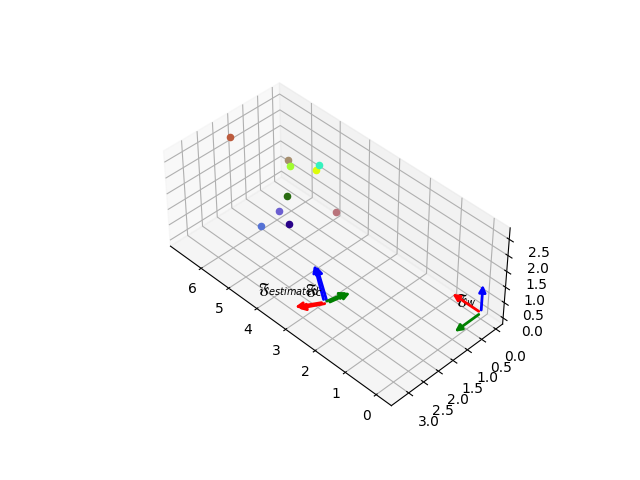

In [16]:
#visualize solution
plotting.add_coordinate_frame(np.linalg.inv(T_op), ax, "$\mathfrak{F}_{estimated}$")
fig